# Introduction

The neural network model classifies whether or not a person has heart disease based on 11 features. The features include: age, gender, cholesterol, resting blood pressure, type of chest pain, maximum heart rate, exercise angina, fasting blood sugar, resting ECG results, and more. The features are the input patterns, and categorical variables are dummy-coded prior to use. The output is binary 0, meaning normal, or 1, indicating heart disease. The dataset was found on Kaggle. The model is trained on the features and predicts whether or not that person has heart disease. The structure included an input layer, two hidden layers, and an output layer. Adam was used as the optimizer and mean squared error as the loss function. Dropout and early stopping were implemented to avoid overfitting to the training data. Performance was assesed using accuracy. The validation accuracy reached 88.04%, indicating the model successfully learned the binary classification task. The model was based off of the Rumelhart example given in class, combined with a previous classification model I created for sentiment analysis. https://www.kaggle.com/code/azizozmen/heart-failure-predict-8-classification-techniques/notebook

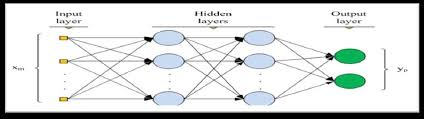

In [1]:
from IPython.display import Image

Image(filename='/Users/madisonherrmann/Downloads/psych755/assignments/NN_wk6/nnpic.jpeg')

Setting working directory

In [2]:
%cd /Users/madisonherrmann/Downloads/psych755/assignments/NN_wk6

/Users/madisonherrmann/Downloads/psych755/assignments/NN_wk6


Loading in packages

In [12]:
!pip install numpy pandas tensorflow matplotlib scipy scikit-learn

import numpy as np  #Provides numpy arrays and methods
import pandas as pd #Provides data frames

#Tensorflow
import tensorflow as tf #Tensorflor and Keras libraries
from tensorflow.keras.layers import Input, Dense, Dropout   #Types of layers we will need
from tensorflow.keras.callbacks import EarlyStopping #Early stopping callback
from tensorflow.keras.models import Model, load_model  #Functions to build and load models
from tensorflow.keras.layers import concatenate        #A function to concatenate layers

#For visualization / analysis
import matplotlib.pyplot as plt #Plotting functions

#Below is for doing some analysis in Python
import scipy.cluster.hierarchy as shc #Python function for hierarchical clustering
from sklearn.manifold import MDS  #Python function for multidimensional scalinga
from sklearn.preprocessing import StandardScaler # For standardizing
from sklearn.model_selection import train_test_split


Load in dataset

In [13]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Look at variable types

In [14]:
print(df.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


Dummy coding necessary variables

In [15]:
df = pd.get_dummies(df, drop_first=True)

Look at shape

In [16]:
df.shape

(918, 16)

Assign input and outputs

In [17]:
X = df.drop(["HeartDisease"], axis=1)
Y = df["HeartDisease"]

Look at shape

In [18]:
X.shape

(918, 15)

In [19]:
Y.shape

(918,)

Split dataset into inputs/outputs for both training and test. The model will be trained on the training data and performance will be evaualted using the held-out test data.

In [20]:
xtrn, xtst, ytrn, ytst = train_test_split(X, Y, test_size=0.1, random_state=42)

Look at shape

In [21]:
xtrn.shape

(826, 15)

In [22]:
ytrn.shape

(826,)

In [23]:
ytst.shape

(92,)

In [24]:
xtst.shape

(92, 15)

Set model parameters

In [25]:
#Set parameters for training here
nepochs = 500 #Number of training epochs
bsize = 4      #Batch size
# Data preprocessing
scaler = StandardScaler()
xtrn_scaled = scaler.fit_transform(xtrn)
xtst_scaled = scaler.transform(xtst)

ytrn = ytrn
ytst = ytst
lrate = .0001 #Learning rate
lossfunction = 'mean_squared_error'  #Loss function
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Building model

In [26]:
input_shape = xtrn.shape[1]
output_units = 1
# Create input layer
xin = Input(shape=(input_shape,), name='input_layer')

# Create hidden layers with dropout and L2 regularization
xhid1 = Dense(units=64, activation='relu', kernel_initializer=wt_init, bias_initializer=wt_init,
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(xin)
xhid1 = Dropout(0.5)(xhid1)
xhid2 = Dense(units=32, activation='relu', kernel_initializer=wt_init, bias_initializer=wt_init,
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(xhid1)
xhid2 = Dropout(0.5)(xhid2)

# Create output layer
xout = Dense(units=output_units, activation='sigmoid', kernel_initializer=wt_init, bias_initializer=wt_init)(xhid2)

# Create model
model = Model(inputs=xin, outputs=xout)

Compile the model

In [27]:
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3137 (12.25 KB)
Trainable params: 3137 (12.25 K

Train the model

In [28]:
# Train the model
H = model.fit(xtrn_scaled, ytrn, epochs=nepochs, batch_size=bsize, validation_data=(xtst_scaled, ytst), callbacks=[early_stopping])

Epoch 1/500
207/207 [==============================] - 2s 5ms/step - loss: 24.1945 - accuracy: 0.5339 - val_loss: 17.6491 - val_accuracy: 0.5543
Epoch 2/500
207/207 [==============================] - 0s 2ms/step - loss: 24.0686 - accuracy: 0.5206 - val_loss: 16.4919 - val_accuracy: 0.5761
Epoch 3/500
207/207 [==============================] - 1s 3ms/step - loss: 22.9560 - accuracy: 0.5218 - val_loss: 15.3432 - val_accuracy: 0.5978
Epoch 4/500
207/207 [==============================] - 0s 2ms/step - loss: 22.1708 - accuracy: 0.5278 - val_loss: 14.5155 - val_accuracy: 0.6630
Epoch 5/500
207/207 [==============================] - 1s 3ms/step - loss: 21.0523 - accuracy: 0.5642 - val_loss: 13.9536 - val_accuracy: 0.6739
Epoch 6/500
207/207 [==============================] - 1s 3ms/step - loss: 20.6197 - accuracy: 0.5787 - val_loss: 13.4249 - val_accuracy: 0.7174
Epoch 7/500
207/207 [==============================] - 0s 2ms/step - loss: 19.8077 - accuracy: 0.5666 - val_loss: 13.1544 - val_ac

Assess loss

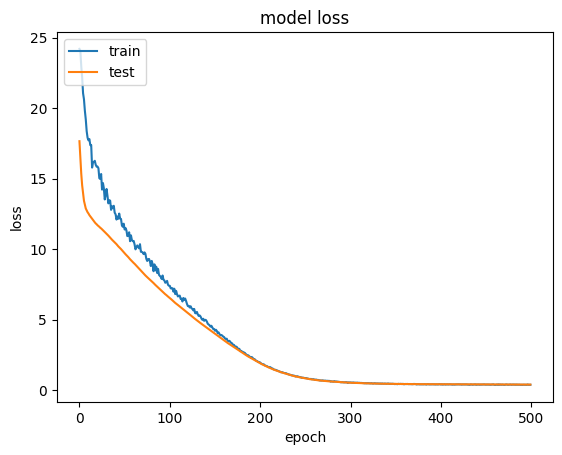

In [29]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Training and validation loss both flatten out near zero, indictating that enough epochs were run.

Assess performance

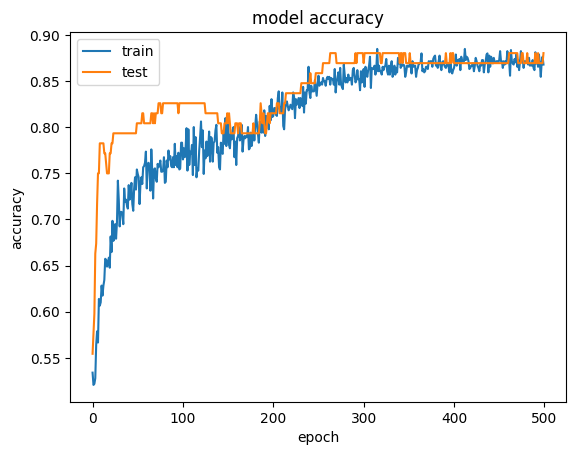

In [30]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Training and validation accuracy flatten at around 85%, indicating that enough epochs were run.

Model performance on test set

In [31]:
model.evaluate(xtst_scaled, ytst, batch_size = bsize)

23/23 [==============================] - 0s 3ms/step - loss: 0.3849 - accuracy: 0.8804


[0.3849221169948578, 0.8804348111152649]